# Prediction of housing prices using Random Forest Regression

## Importing libraries

In [1]:
import pandas as pd

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

## Reading training set of data

In [2]:
TRAINING_SET_PATH = '../dataset/train.csv'
training_set = pd.read_csv(TRAINING_SET_PATH)
training_set.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


## Data Preprocessing

### Handling missing values

In [3]:
def display_missing_values(df):
    missing_values = df.isnull().sum().to_frame()
    missing_values.columns = ['Missing_Values']
    missing_values = missing_values.query('Missing_Values > 0')
    print(missing_values)

display_missing_values(training_set)

              Missing_Values
LotFrontage              259
Alley                   1369
MasVnrType               872
MasVnrArea                 8
BsmtQual                  37
BsmtCond                  37
BsmtExposure              38
BsmtFinType1              37
BsmtFinType2              38
Electrical                 1
FireplaceQu              690
GarageType                81
GarageYrBlt               81
GarageFinish              81
GarageQual                81
GarageCond                81
PoolQC                  1453
Fence                   1179
MiscFeature             1406


#### Dropping outlier rows

Observed in the above cell output, columns *MasVnrArea* and *Electrical* have very low numbers of missing values within.

It is safe to drop the corresponding rows without having a significant impact to the model.

In [4]:
cleaned_set = training_set
cleaned_set.dropna(axis=0, subset=['MasVnrArea', 'Electrical'], inplace=True)
display_missing_values(cleaned_set)

              Missing_Values
LotFrontage              257
Alley                   1361
MasVnrType               863
BsmtQual                  37
BsmtCond                  37
BsmtExposure              38
BsmtFinType1              37
BsmtFinType2              38
FireplaceQu              685
GarageType                81
GarageYrBlt               81
GarageFinish              81
GarageQual                81
GarageCond                81
PoolQC                  1444
Fence                   1170
MiscFeature             1397


#### Handling Bsmt

Upon further inspection in the dataset, rows with NA *BsmtQual* have NA values for the rest of *BsmtColumns*

It would be suitable to create a new column of binary value to indicate whether the row has a *Bsmt*

In [5]:
# Inspecting rows with NA BsmtQual
mask = cleaned_set['BsmtQual'].isna()
cols = ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2')
cleaned_set.loc[mask, cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
17,NaN,NaN,NaN,NaN,NaN
39,NaN,NaN,NaN,NaN,NaN
90,NaN,NaN,NaN,NaN,NaN
102,NaN,NaN,NaN,NaN,NaN
156,NaN,NaN,NaN,NaN,NaN
182,NaN,NaN,NaN,NaN,NaN
259,NaN,NaN,NaN,NaN,NaN
342,NaN,NaN,NaN,NaN,NaN
362,NaN,NaN,NaN,NaN,NaN
371,NaN,NaN,NaN,NaN,NaN


In [6]:
# Creating a indicator column
cleaned_set = cleaned_set.assign(BsmtIncluded=training_set['BsmtQual'].notna())

# Replaceing NA with an arbitrary value
mask = cleaned_set['BsmtQual'].isna()
cols = ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2')
cleaned_set.loc[mask, cols] = 0

display_missing_values(cleaned_set)

              Missing_Values
LotFrontage              257
Alley                   1361
MasVnrType               863
BsmtExposure               1
BsmtFinType2               1
FireplaceQu              685
GarageType                81
GarageYrBlt               81
GarageFinish              81
GarageQual                81
GarageCond                81
PoolQC                  1444
Fence                   1170
MiscFeature             1397


Since there are only 1 missing value left for *BsmtExposure* and *BsmtFinType2*, the corresponding row can be dropped.

In [7]:
cleaned_set = cleaned_set.dropna(axis=0, subset=['BsmtExposure', 'BsmtFinType2'])
display_missing_values(cleaned_set)

              Missing_Values
LotFrontage              257
Alley                   1359
MasVnrType               863
FireplaceQu              685
GarageType                81
GarageYrBlt               81
GarageFinish              81
GarageQual                81
GarageCond                81
PoolQC                  1442
Fence                   1168
MiscFeature             1395


#### Handling Garage

Upon further inspection in the dataset, rows with NA *GarageType* have NA values for the rest of *GarageColumns*

It would be suitable to create a new column of binary value to indicate whether the row has a garage

In [8]:
# Inspecting rows with NA GarageType
mask = cleaned_set['GarageType'].isna()
cols = ('GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond')
cleaned_set.loc[mask, cols]

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
39,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN
78,NaN,NaN,NaN,NaN,NaN
88,NaN,NaN,NaN,NaN,NaN
89,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
1349,NaN,NaN,NaN,NaN,NaN
1407,NaN,NaN,NaN,NaN,NaN
1449,NaN,NaN,NaN,NaN,NaN
1450,NaN,NaN,NaN,NaN,NaN


In [9]:
# Creating a indicator column
cleaned_set = cleaned_set.assign(GarageIncluded=training_set['GarageType'].notna())

# Replaceing NA with an arbitrary value
mask = cleaned_set['GarageType'].isna()
cols = ('GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond')
cleaned_set.loc[mask, cols] = 0

display_missing_values(cleaned_set)

             Missing_Values
LotFrontage             257
Alley                  1359
MasVnrType              863
FireplaceQu             685
PoolQC                 1442
Fence                  1168
MiscFeature            1395


#### Handling Alley

It is observed that *Alley* is a nominal feature. NAs in *Alley* are replaced with *'No_Alley'* for now, which will be further processed and encoded.

In [10]:
cleaned_set['Alley'].unique()

array([nan, 'Grvl', 'Pave'], dtype=object)

In [11]:
mask = cleaned_set['Alley'].isna()
cleaned_set.loc[mask, 'Alley'] = 'No_Alley'
display_missing_values(cleaned_set)

             Missing_Values
LotFrontage             257
MasVnrType              863
FireplaceQu             685
PoolQC                 1442
Fence                  1168
MiscFeature            1395


#### Handling MasVnrType

Again, *MasVnrType* is a nominal feature, NAs are replaced with *'No_MasVnrType'* for further encoding.

In [12]:
cleaned_set['MasVnrType'].unique()

array(['BrkFace', nan, 'Stone', 'BrkCmn'], dtype=object)

In [15]:
mask = cleaned_set['MasVnrType'].isna()
cleaned_set.loc[mask, 'MasVnrType'] = 'No_MasVnrType'
display_missing_values(cleaned_set)

             Missing_Values
LotFrontage             257
PoolQC                 1442
Fence                  1168
MiscFeature            1395


#### Handling FireplaceQu

Same approach for *FireplaceQu*

In [13]:
cleaned_set['FireplaceQu'].unique()

array([nan, 'TA', 'Gd', 'Fa', 'Ex', 'Po'], dtype=object)

In [17]:
mask = cleaned_set['FireplaceQu'].isna()
cleaned_set.loc[mask, 'FireplaceQu'] = 'No_FireplaceQu'
display_missing_values(cleaned_set)

             Missing_Values
LotFrontage             257
PoolQC                 1442
Fence                  1168
MiscFeature            1395


#### Handling PoolQC

Same approach for *PoolQC*

In [19]:
cleaned_set['PoolQC'].unique()

array([nan, 'Ex', 'Fa', 'Gd'], dtype=object)

In [20]:
mask = cleaned_set['PoolQC'].isna()
cleaned_set.loc[mask, 'PoolQC'] = 'No_PoolQC'
display_missing_values(cleaned_set)

             Missing_Values
LotFrontage             257
Fence                  1168
MiscFeature            1395


#### Handling Fence

Same approach for *Fence*

In [21]:
cleaned_set['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [22]:
mask = cleaned_set['Fence'].isna()
cleaned_set.loc[mask, 'Fence'] = 'No_Fence'
display_missing_values(cleaned_set)

             Missing_Values
LotFrontage             257
MiscFeature            1395


#### Handling MiscFeature

Same approach for *MiscFeature*

In [23]:
cleaned_set['MiscFeature'].unique()

array([nan, 'Shed', 'Gar2', 'Othr', 'TenC'], dtype=object)

In [24]:
mask = cleaned_set['MiscFeature'].isna()
cleaned_set.loc[mask, 'MiscFeature'] = 'No_MiscFeature'
display_missing_values(cleaned_set)

             Missing_Values
LotFrontage             257


#### Handling LotFrontage

ChatGPT said:

    Observations:

        Positive Correlation: 
            The graph demonstrates a general positive correlation between LotArea and LotFrontage, as higher LotArea values are associated with higher LotFrontage values.
        
        Clustering:
            Most of the data points form a tight cluster, which suggests a consistent relationship. However, some outliers are present, particularly at higher LotArea values, which may reduce prediction accuracy.
        
        Logarithmic Scaling:
            The log-log scaling normalizes the spread of the data and highlights a pattern, which could be modeled effectively with a regression or other predictive techniques.

    Suitability for Prediction:

        Strengths:
            The positive trend between the two variables indicates that LotArea can help estimate LotFrontage.
            The clustering of data points implies that a predictive model could capture this relationship reasonably well for most of the data.

        Challenges:
            The presence of outliers may introduce noise into the model, requiring preprocessing or robust modeling techniques.
            The spread of data points at higher LotArea values might make predictions less precise for large properties.

<Axes: xlabel='LotArea', ylabel='LotFrontage'>

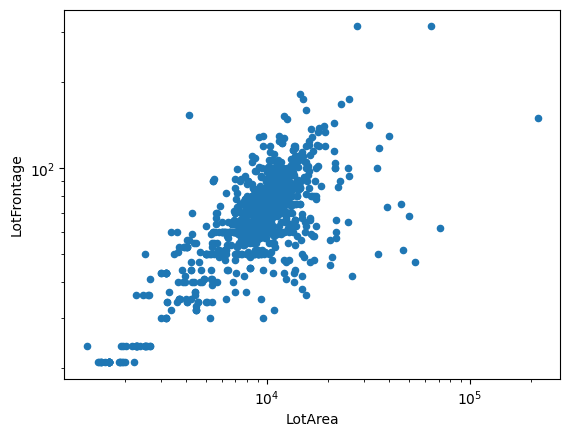

In [52]:
mask = cleaned_set['LotFrontage'].notna()
cols = ('LotArea', 'LotFrontage', 'SalePrice')
plot = cleaned_set.loc[mask, cols].plot.scatter(x='LotArea', y='LotFrontage', loglog=True)
plot